# Imágenes Biomédicas. Proyecto 2.
**Diego Moreno**

Importamos las librerías:

In [1]:
import dipy
import nibabel as nib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.optimize import curve_fit
from scipy.optimize import leastsq
from sklearn.linear_model import Lasso
import warnings
warnings.filterwarnings("ignore")

In [2]:
from dipy.io.image import load_nifti, save_nifti
from dipy.io.gradients import read_bvals_bvecs
from dipy.core.gradients import gradient_table
import dipy.reconst.dti as dti
from dipy.data import get_fnames
from dipy.reconst.dti import fractional_anisotropy, color_fa
from dipy.data import get_sphere

In [3]:
import dipy.reconst.dki as dki
import dipy.reconst.dti as dti
from dipy.data import fetch_cfin_multib
from dipy.data import read_cfin_dwi
from dipy.segment.mask import median_otsu
from scipy.ndimage.filters import gaussian_filter

## A) Realizamos el tutorial.

In [17]:
fetch_cfin_multib()

img, gtab = read_cfin_dwi()

data = img.get_data()

affine = img.affine

<ipython-input-17-7930dcc34e1e>:5: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  data = img.get_data()


In [18]:
maskdata, mask = median_otsu(data, vol_idx=[0, 1],
                             median_radius=4, numpass=2,
                             autocrop=False, dilate=1)

In [19]:
fwhm = 1.25
gauss_std = fwhm / np.sqrt(8 * np.log(2))  # converting fwhm to Gaussian std
data_smooth = np.zeros(data.shape)
for v in range(data.shape[-1]):
    data_smooth[..., v] = gaussian_filter(data[..., v], sigma=gauss_std)

In [20]:
dkimodel = dki.DiffusionKurtosisModel(gtab)

In [21]:
dkifit = dkimodel.fit(data_smooth, mask=mask)

In [22]:
FA = dkifit.fa
MD = dkifit.md
AD = dkifit.ad
RD = dkifit.rd

In [23]:
tenmodel = dti.TensorModel(gtab)
tenfit = tenmodel.fit(data_smooth, mask=mask)

dti_FA = tenfit.fa
dti_MD = tenfit.md
dti_AD = tenfit.ad
dti_RD = tenfit.rd

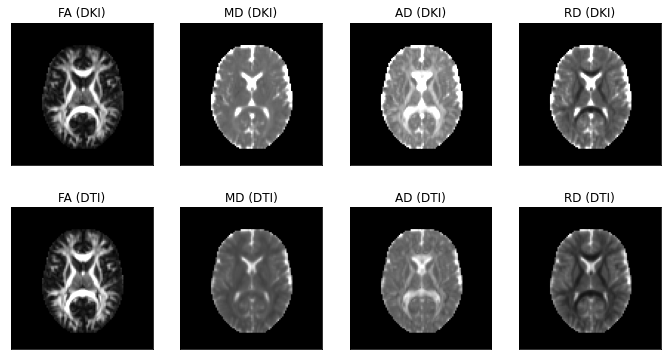

In [24]:
axial_slice = 9

fig1, ax = plt.subplots(2, 4, figsize=(12, 6),
                        subplot_kw={'xticks': [], 'yticks': []})

fig1.subplots_adjust(hspace=0.3, wspace=0.05)

ax.flat[0].imshow(FA[:, :, axial_slice].T, cmap='gray',
                  vmin=0, vmax=0.7, origin='lower')
ax.flat[0].set_title('FA (DKI)')
ax.flat[1].imshow(MD[:, :, axial_slice].T, cmap='gray',
                  vmin=0, vmax=2.0e-3, origin='lower')
ax.flat[1].set_title('MD (DKI)')
ax.flat[2].imshow(AD[:, :, axial_slice].T, cmap='gray',
                  vmin=0, vmax=2.0e-3, origin='lower')
ax.flat[2].set_title('AD (DKI)')
ax.flat[3].imshow(RD[:, :, axial_slice].T, cmap='gray',
                  vmin=0, vmax=2.0e-3, origin='lower')
ax.flat[3].set_title('RD (DKI)')

ax.flat[4].imshow(dti_FA[:, :, axial_slice].T, cmap='gray',
                  vmin=0, vmax=0.7, origin='lower')
ax.flat[4].set_title('FA (DTI)')
ax.flat[5].imshow(dti_MD[:, :, axial_slice].T, cmap='gray',
                  vmin=0, vmax=2.0e-3, origin='lower')
ax.flat[5].set_title('MD (DTI)')
ax.flat[6].imshow(dti_AD[:, :, axial_slice].T, cmap='gray',
                  vmin=0, vmax=2.0e-3, origin='lower')
ax.flat[6].set_title('AD (DTI)')
ax.flat[7].imshow(dti_RD[:, :, axial_slice].T, cmap='gray',
                  vmin=0, vmax=2.0e-3, origin='lower')
ax.flat[7].set_title('RD (DTI)')

plt.show()
fig1.savefig('Diffusion_tensor_measures_from_DTI_and_DKI.png')

In [25]:
MK = dkifit.mk(0, 3)
AK = dkifit.ak(0, 3)
RK = dkifit.rk(0, 3)

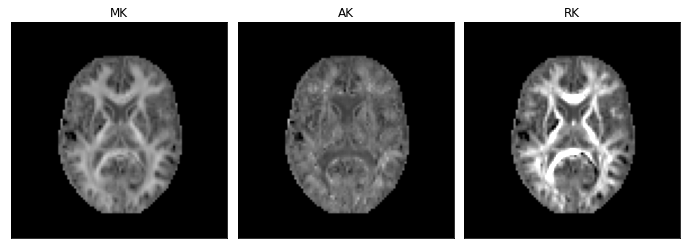

In [26]:
fig2, ax = plt.subplots(1, 3, figsize=(12, 6),
                        subplot_kw={'xticks': [], 'yticks': []})

fig2.subplots_adjust(hspace=0.3, wspace=0.05)

ax.flat[0].imshow(MK[:, :, axial_slice].T, cmap='gray', vmin=0, vmax=1.5,
                  origin='lower')
ax.flat[0].set_title('MK')
ax.flat[1].imshow(AK[:, :, axial_slice].T, cmap='gray', vmin=0, vmax=1.5,
                  origin='lower')
ax.flat[1].set_title('AK')
ax.flat[2].imshow(RK[:, :, axial_slice].T, cmap='gray', vmin=0, vmax=1.5,
                  origin='lower')
ax.flat[2].set_title('RK')

plt.show()
fig2.savefig('Kurtosis_tensor_standard_measures.png')

### Solución para detectar no-Gaussianidad en regiones
Definiremos un threshold para rescatar las regiones que tienen más alto FA dado el modelo de difusión de kurtois para detectar la no-Gaussianidad. Suponiendo que con dicho threshold va a rescatar regiones de voxeles vecinos que tiene no-Gaussianidad.

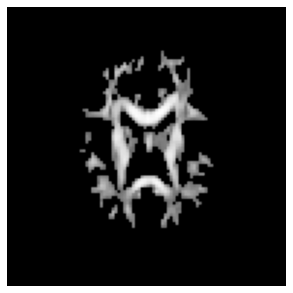

In [66]:
threshold = 0.3
idx = dkifit.fa < threshold
img = dkifit.fa.copy()
img[idx] = 0.
plt.figure(figsize=(5,10))
plt.imshow(img[:,:,12].T, 'Greys_r')
plt.axis('off')
plt.show()

# B). Calcular la deconvolucion esférica en MRTrix

1. Instalamos MRTrix.

2. Calculamos la funcion de respuesta: esto se calculo usando las funciones de MRTRix. La creamos con:

*dwi2response tournier Sujeto1_DWI_data.mif Sujeto1_DWI_data.txt*

A continuación una imagen de la respuesta creada:


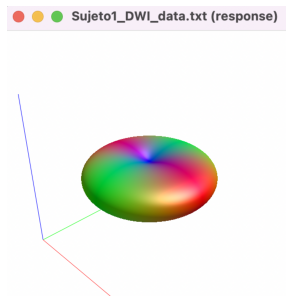

In [68]:
plt.figure(figsize=(5,10))
plt.imshow(plt.imread('respuesta.png'))
plt.axis('off')
plt.show()

Luego, para visualizar las orientaciones de los manojos primero creamos una máscara con:

*dwi2mask Sujeto1_DWI_data.mif Sujeto1_DWI_data_MASK.nii*

Luego, calculamos las orientaciones con:

*dwi2fod csd Sujeto1_DWI_data.mif Sujeto1_DWI_data.txt Sujeto1_DWI_data_FOD.nii -mask Sujeto1_DWI_data_MASK.nii*

Finalmente mostramos las imágenes con:

*mrview Sujeto1_DWI_data.mif -odf.load_sh Sujeto1_DWI_data_FOD.nii*

A continuación una muestra de las imágenes con escala de las respuestas igual a 3:

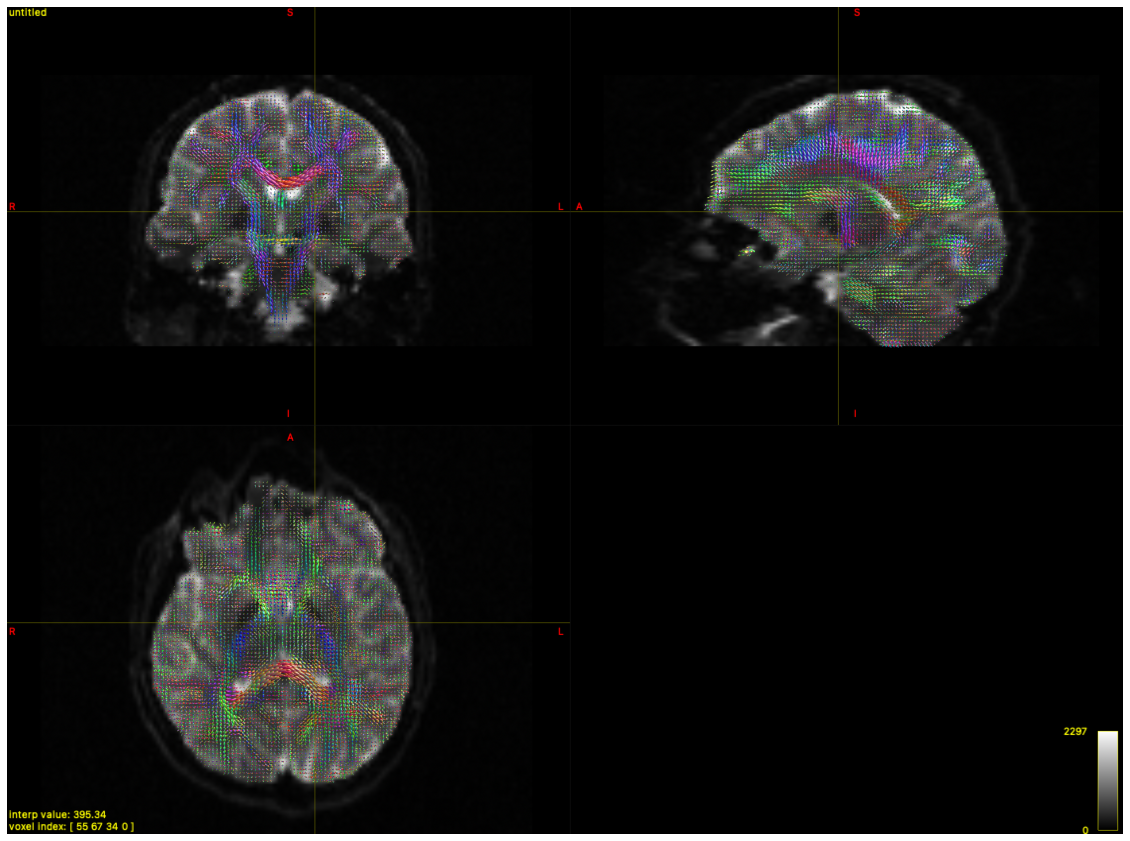

In [72]:
plt.figure(figsize=(20,20))
plt.imshow(plt.imread('orientaciones.png'))
plt.axis('off')
plt.show()

# C) Implementar el Diffusion Basis Functions

Cargamos los datos de la tarea 1.

In [4]:
data3 = pd.read_csv('NODDI_DWI.scheme', sep='\n', engine='python', header=None).loc[:,0]
data = [np.array(data3[i].split()).astype(np.float64).tolist()\
        for i in range(1,len(data3))]
data = np.array(data)

In [5]:
maskdata, affine  = load_nifti('NODDI_DWI.nii')
mask,     affine2 = load_nifti('BRAIN_MASK.nii')

In [6]:
maskdata = maskdata.squeeze(3)
maskdata.shape

(128, 128, 50, 81)

Como el modelo de difusion de kurtois no admite menos de 3 bvalores lo ajustamos con todos los bvalores que tenemos:

In [7]:
def get_bvals(G, DELTA, delta):
    #Definir gyromagnetic ratio:
    gmr = 2*np.pi*42.576*1e6 #de MHZ/T -> rad/(sec T)
    bval = (gmr * delta * G)**2 * (DELTA - delta/3)  # en s/m^2
    return bval*1e-6

In [8]:
bvals = get_bvals(data[:, 3], data[:, 4], data[:, 5])
bvecs = data[:, :3]
gtab = gradient_table(bvals, bvecs)

In [9]:
fwhm = 1.25
gauss_std = fwhm / np.sqrt(8 * np.log(2))  # converting fwhm to Gaussian std
data_smooth = np.zeros(maskdata.shape)
for v in range(maskdata.shape[-1]):
    data_smooth[..., v] = gaussian_filter(maskdata[..., v], sigma=gauss_std)
    
dkimodel = dki.DiffusionKurtosisModel(gtab)
dkifit = dkimodel.fit(data_smooth, mask=mask)

In [10]:
FA = dkifit.fa
FA[np.isnan(FA)] = 0

Nos quedamos con los de valor $b=2000$.

In [11]:
# Solo con valores 2000 de b
idx = bvals == bvals[-1] # Es un valor de 2000
idx[0] = True # Valor 0
bvals = bvals[idx]
bvecs = data[:, :3][idx]
#gtab = gradient_table(bvals, bvecs)
#maskdata = maskdata[:, :, :, idx]
#maskdata.shape

In [12]:
idx = gtab.bvals == bvals[0]
S0 = data_smooth[:, :, :, idx].T
S0 = S0.sum(axis=0).T
idx = gtab.bvals == bvals[-1]
S_hat = data_smooth[:, :, :, idx]

### Tesor de difusion base para hacer el diccionario de direcciones

Nos quedamos solo con valores de FA > 0.7

In [13]:
data3 = pd.read_csv('DBF_129orientations.dat', sep='\n', engine='python', header=None).loc[:,0]
orients = [np.array(data3[i].split()).astype(np.float64).tolist()\
        for i in range(len(data3))]
orients = np.array(orients)

In [14]:
from rotation_matrix_from_vectors import rotation_matrix_from_vectors as rmv

(-0.3537829686851439, -0.0042953044923757806, -0.9353176794157396)
[-0.35378297 -0.0042953  -0.93531768]


In [15]:
idx = dkifit.fa > 0.7
# Medias 
evals_mean = np.mean(dkifit.evals[idx], axis=0)
mean = np.mean(evals_mean[1:3])
Dk = np.diag([evals_mean[0], mean, mean])

In [16]:
idx = gtab.bvals == bvals[-1]
Phi = np.zeros((gtab.bvecs[idx, :].shape[0], orients.shape[0]))

ejex = np.array([1., 0., 0.])
for i, n in enumerate(orients):  
    if i != 1:
        mat = rmv(ejex, n)
        D_rot = mat@Dk@mat
    else:
        D_rot = Dk
    for j, g_i in enumerate(gtab.bvecs[idx, :]):
        Phi[j, i] = np.exp(-bvals[-1]*g_i.T@D_rot@g_i)
Phi.shape

(48, 129)

Ajustamos las alphas con Lasso:

In [17]:
alphas = np.zeros((S_hat.shape[0], S_hat.shape[1], S_hat.shape[2], Phi.shape[1]))
idx = FA > 0.30
lasso = Lasso(alpha=1.5, fit_intercept=False, positive=True, max_iter=3000)

for i in range(S_hat.shape[0]):
    for j in range(S_hat.shape[1]):
        for k in range(S_hat.shape[2]):
            if idx[i, j, k]:
                S0_aux = S0[i, j, k]
                S = S_hat[i, j, k, :]
                alpha = lasso.fit(S0_aux*Phi, S)
                alphas[i, j, k, :] = alpha.coef_

In [18]:
alphas.shape

(128, 128, 50, 129)

Visualizamos unos vóxeles para comparar con la kurtosis:

In [19]:
idx = FA > 0.30
tajada = S_hat.shape[2]
s_tajada = (S_hat[:, :, tajada//2, :].T*idx[:, :, tajada//2].T).T
S_hat_lasso = np.zeros(s_tajada.shape)
for x in range(s_tajada.shape[0]):
    for y in range(s_tajada.shape[1]):
        if idx[x, y, tajada//2]:
            S0_aux = S0[x, y, tajada//2]
            S_hat_lasso[x, y, :] = (S0_aux*Phi)@ alphas[x,y,tajada//2,:]    

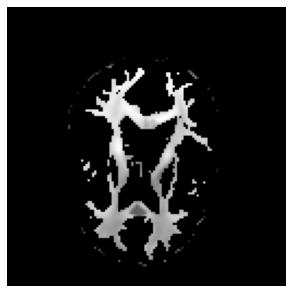

In [20]:
plt.figure(figsize=(5,10))
plt.imshow(S_hat_lasso[:,:,12].T, 'Greys_r')
plt.axis('off')
plt.show()

Notamos que si hay una gran similitud de correlación en las zonas del cerebro resaltadas entre lo obtenido con este ajuste y donde la no-Gaussianidad es detectada por la kurtosis anteriormente pues la imagen generada por la kurtosis tiene las mismas zonas para esta tajada del cerebro. 


# D) Generamos los siguientes archivos necesarios para la visualizacion con mrview:

Junto con MRTrix vamos a convertir la imagen que tenemos de NODDI_DWI.nii a una .mif agregandole la gtab correspondiente con:

*mrconvert sujetoNODDI.nii sujetoNODDI.mif -grad DBF_grad_table.txt*

Para despues visualizar con:

*mrview sujetoNODDI.mif -odf.load_sh DBF_salida.nii*

La DBF_salida.nii fue obtenida con:

*amp2sh alphas.nii -grad DBF_129orientations.txt DBF_salida.mif*

archivos que creamos aqui abajo:

In [21]:
save_nifti('alphas.nii', alphas.astype(np.float32), affine)

In [22]:
txt = open('DBF_129orientations.txt','w')
for i in range(orients.shape[0]):
    txt.write(str(orients[i][0])+' '+\
              str(orients[i][1])+' '+\
              str(orients[i][2])+' '+\
              str(bvals[-1])+'\n')
txt.close()

In [23]:
txt = open('DBF_grad_table.txt','w')
idx = bvals==bvals[-1]
idx[0] = True
for i in range(sum(idx)):
    txt.write(str(gtab.bvecs[idx][i][0])+' '+\
              str(gtab.bvecs[idx][i][1])+' '+\
              str(gtab.bvecs[idx][i][2])+' '+\
              str(gtab.bvals[idx][i])+'\n')
txt.close()

IndexError: boolean index did not match indexed array along dimension 0; dimension is 81 but corresponding boolean dimension is 49

In [24]:
maskdata_2 = maskdata[:,:,:,idx]

IndexError: boolean index did not match indexed array along dimension 3; dimension is 81 but corresponding boolean dimension is 49

In [ ]:
save_nifti('sujetoNODDI.nii', maskdata_2, affine)

Visualizamos las imagenes obtenidas con mrview:

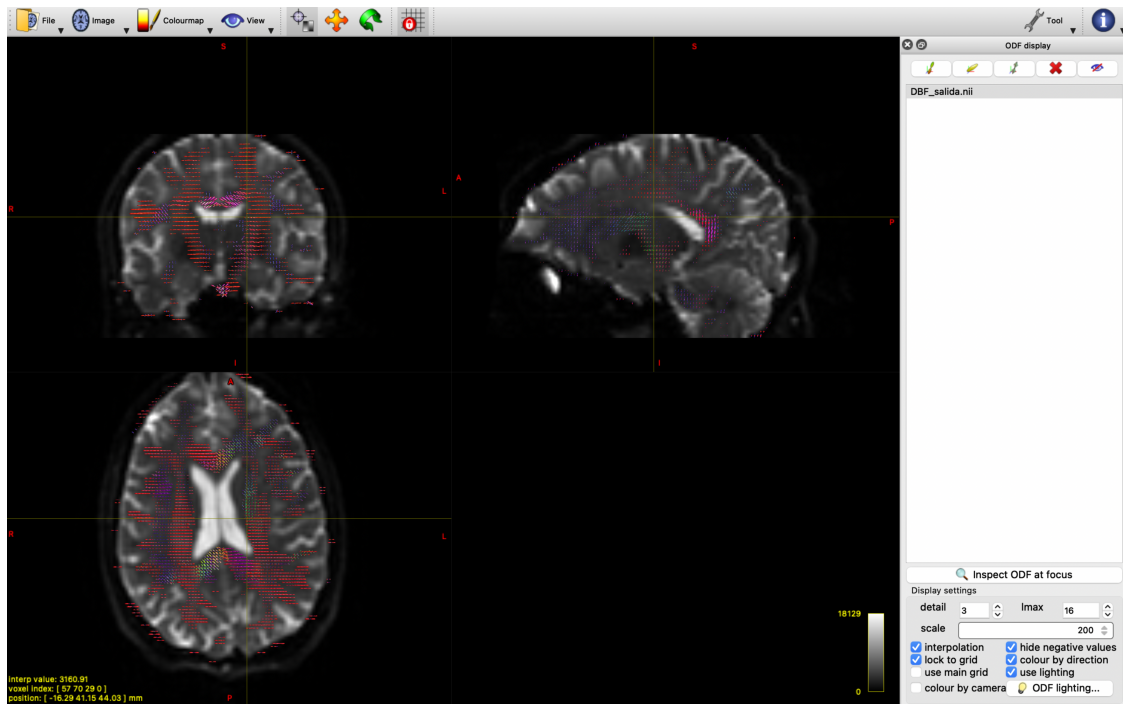

In [103]:
plt.figure(figsize=(20,20))
plt.imshow(plt.imread('mrview1.png'))
plt.axis('off')
plt.show()

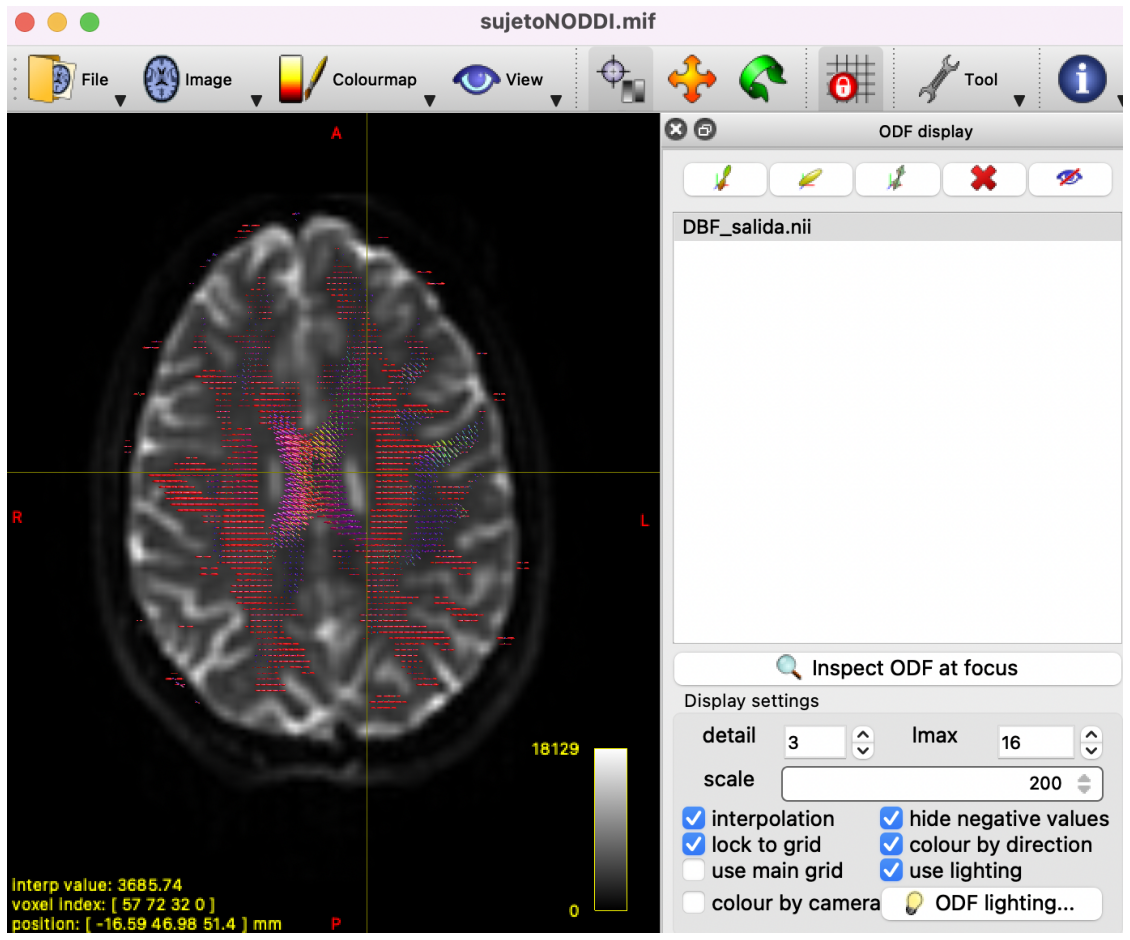

In [107]:
plt.figure(figsize=(20,20))
plt.imshow(plt.imread('mrview2.png'))
plt.axis('off')
plt.show()

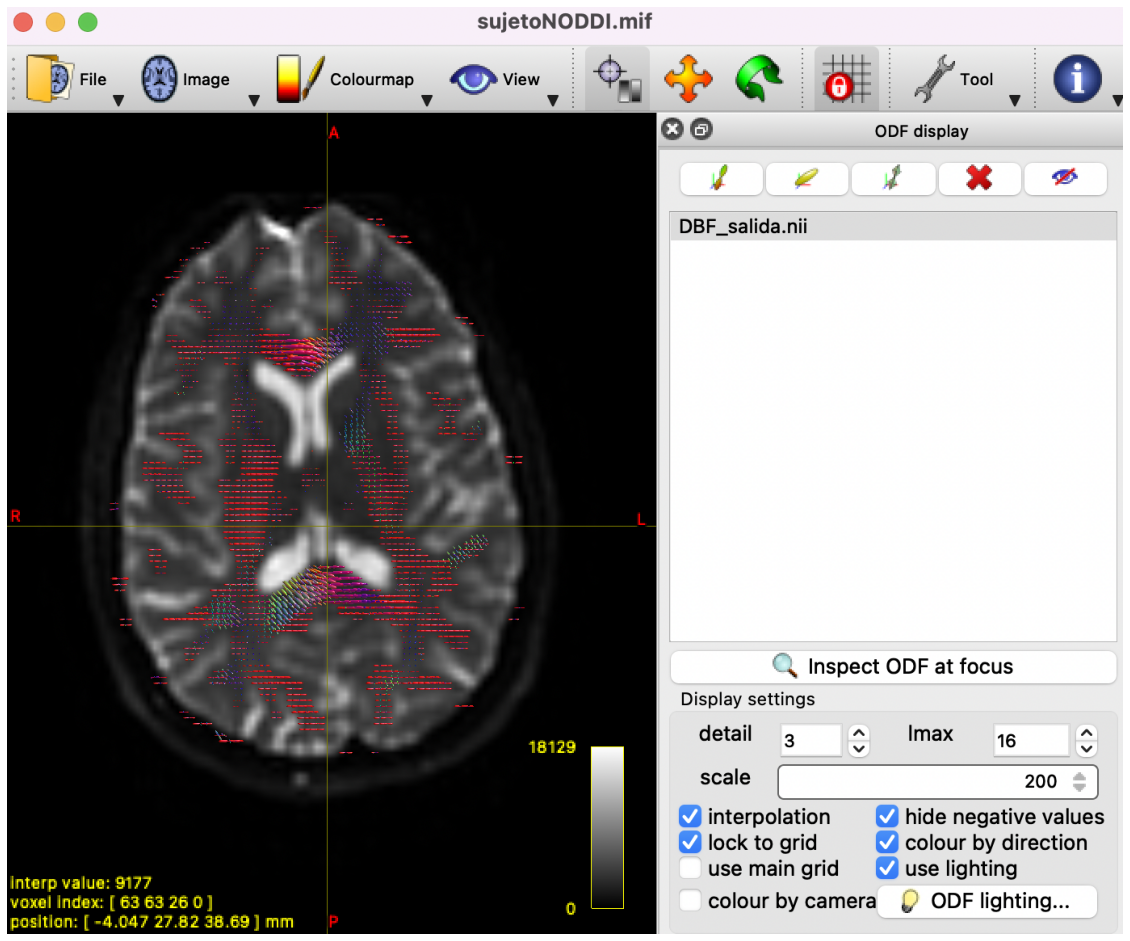

In [108]:
plt.figure(figsize=(20,20))
plt.imshow(plt.imread('mrview3.png'))
plt.axis('off')
plt.show()